# Salinity comparison with MEOP data

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as col
from scipy import interpolate

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/Weddell_connectivity/obs/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44325/status,
Dashboard: /proxy/44325/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37811,Workers: 4
Dashboard: /proxy/44325/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:43251,Total threads: 4
Dashboard: /proxy/38267/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:42331,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
ryf = '01deg_jra55v13_ryf9091'
cycle2 = '01deg_jra55v140_iaf_cycle2'
cycle3 = '01deg_jra55v140_iaf_cycle3'

start_time='2150-01-01'
end_time='2159-12-31'

lon_slice  = slice(-120, -50)
lat_slice  = slice(-75.5,-60)

In [4]:
# topography data for plotting:
ht = cc.querying.getvar(ryf,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

# bottom cell indices:
kmt = cc.querying.getvar(ryf,'kmt',master_session, n=-1)
kmt = kmt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
kmt = kmt.fillna(1.0).astype(int) - 1
kmt.load()

fontsize=16

In [5]:
# Shelf mask to check if profiles are on shelf or not:

# Note this is on the t grid
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_map = np.nan_to_num(shelf_mask)
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
shelf_map = shelf_map.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

## Select out obs profiles in correct region:

In [6]:
%%time

# do some testing to see which seal data is in the right region:
# Need to consider profiles from Brazil, Germany, UK, USA
# I think the interpolated data is fine to use here, because I only want profiles < 1000m.

path2files   = '/g/data/v45/akm157/data/meop_seal_data/'
FileList = glob(path2files+'*/DATA_ncARGO/*')
FileList.sort()

WAP_FileList = []
for file in FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    # check if in West Antarctic Peninsula box:
    WAP_box=lat.where(lon>-120).where(lon<-50).where(lat<-60).dropna(dim='N_PROF')
    if len(WAP_box)>0:
        WAP_FileList += [file]

CPU times: user 23.5 s, sys: 2.3 s, total: 25.8 s
Wall time: 27.1 s


In [7]:
%%time

# Now go through the profiles in the WAP box and select out all profiles on the shelf:
# We also need salinity, to convert in situ temp to conservative temp.

# I have checked TEMP_ADJUSTED_QC,PSAL_ADJUSTED_QC,PRES_ADJUSTED_QC=1 for all profiles used.

nprofiles = 22312 # 47636
ndepth = 22
temp = np.zeros((nprofiles,ndepth))
#saltQC = np.zeros((nprofiles,ndepth))
#presQC = np.zeros((nprofiles,ndepth))
salt = np.zeros((nprofiles,ndepth))
pres = np.zeros((nprofiles,ndepth))
lon_obs = np.zeros((nprofiles))
lat_obs = np.zeros((nprofiles))
date = []
profile_count = 0

file_count = 1
for file in WAP_FileList:
    print('file '+str(file_count)+'/'+str(len(WAP_FileList)))
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    # go through each profile and find nearest model grid point:
    for profile in range(len(lat)):
        # NOTE THAT LONGITUDE IS NOT ADJUSTED FOR THE MODEL RANGE HERE, BECAUSE RANGE ON PENINSULA IS OK
        # BUT THIS WILL NOT WORK ELSEWHERE!!
        on_shelf = shelf_map.sel(xt_ocean=lon[profile],method='nearest').sel(yt_ocean=lat[profile],method='nearest')
        if on_shelf>0:
            # check temp has at least 2 data points:
            temp_profile = profile_data.TEMP_ADJUSTED[profile]
            if len(np.where((temp_profile!=0.)&(~np.isnan(temp_profile)))[0]) > 2:
                # check the dive reached at least 200 dbar:
                pres_profile = profile_data.PRES_ADJUSTED[profile]
                if pres_profile.max() >= 450:
                    date = np.append(date,profile_data.JULD[profile])
                    # save profile:
                    lat_obs[profile_count] = lat[profile]
                    lon_obs[profile_count] = lon[profile]
                    # find depth of profile:
                    nlevels = len(profile_data.PRES_ADJUSTED[profile])
                    temp[profile_count,:nlevels] = temp_profile
                    salt_profile = profile_data.PSAL_ADJUSTED[profile]
                    salt[profile_count,:nlevels] = salt_profile
                    #saltQC_profile = profile_data.PSAL_ADJUSTED_QC[profile]
                    #saltQC[profile_count,:nlevels] = saltQC_profile
                    #presQC_profile = profile_data.PRES_ADJUSTED_QC[profile]
                    #presQC[profile_count,:nlevels] = presQC_profile
                    pres[profile_count,:nlevels] = pres_profile
                    profile_count += 1
    file_count += 1
# Wall time: 

file 1/165
file 2/165
file 3/165
file 4/165
file 5/165
file 6/165
file 7/165
file 8/165
file 9/165
file 10/165
file 11/165
file 12/165
file 13/165
file 14/165
file 15/165
file 16/165
file 17/165
file 18/165
file 19/165
file 20/165
file 21/165
file 22/165
file 23/165
file 24/165
file 25/165
file 26/165
file 27/165
file 28/165
file 29/165
file 30/165
file 31/165
file 32/165
file 33/165
file 34/165
file 35/165
file 36/165
file 37/165
file 38/165
file 39/165
file 40/165
file 41/165
file 42/165
file 43/165
file 44/165
file 45/165
file 46/165
file 47/165
file 48/165
file 49/165
file 50/165
file 51/165
file 52/165
file 53/165
file 54/165
file 55/165
file 56/165
file 57/165
file 58/165
file 59/165
file 60/165
file 61/165
file 62/165
file 63/165
file 64/165
file 65/165
file 66/165
file 67/165
file 68/165
file 69/165
file 70/165
file 71/165
file 72/165
file 73/165
file 74/165
file 75/165
file 76/165
file 77/165
file 78/165
file 79/165
file 80/165
file 81/165
file 82/165
file 83/165
file 84/165
f

## Interpolate MEOP profiles onto model depth grid and convert to conservative temp:


In [11]:
# convert to absolute salinity:
from gsw import SA_from_SP
salt_abs = SA_from_SP(salt,pres,np.tile(lon_obs,(ndepth,1)).swapaxes(0,1),np.tile(lat_obs,(ndepth,1)).swapaxes(0,1))

In [12]:
# convert to conservative temp:
from gsw import CT_from_t
temp_conservative = CT_from_t(salt_abs,temp,pres)

In [13]:
# convert pressure to depth:
from gsw import z_from_p
z = -z_from_p(pres,np.tile(lat_obs,(ndepth,1)).swapaxes(0,1))

In [14]:
%%time
# Interpolate to model point nearest 450m:
st_ocean = cc.querying.getvar(ryf,'st_ocean' , master_session,n=1)
model_depth = st_ocean.sel(st_ocean=450,method='nearest')

temp_interp = np.zeros((nprofiles))
salt_interp = np.zeros((nprofiles))

max_profile_depth = z.max(axis=1)

for profile in range(nprofiles):
    # select out available pressure range of data:
    z_profile = z[profile,:][z[profile,:]>0]
    temp_profile = temp_conservative[profile,:][z[profile,:]>0]
    salt_profile = salt_abs[profile,:][z[profile,:]>0]
    # check profile is deep enough:
    # keep if within 70m of model depth (468.4475154m)
    if max_profile_depth[profile] < model_depth-70:
        # else set all to nans:
        temp_profile = temp_profile*np.nan
        salt_profile = salt_profile*np.nan
    
    f = interpolate.interp1d(z_profile,temp_profile,bounds_error=False,fill_value="extrapolate")
    g = interpolate.interp1d(z_profile,salt_profile,bounds_error=False,fill_value="extrapolate")
    temp_interp[profile] = f(model_depth)
    salt_interp[profile] = g(model_depth)
# Wall time: 10.2 s

CPU times: user 14.6 s, sys: 1.38 s, total: 16 s
Wall time: 14.8 s


In [15]:
lon_obs = lon_obs[~np.isnan(temp_interp)]
lat_obs = lat_obs[~np.isnan(temp_interp)]

In [16]:
# date = date[~np.isnan(temp_interp)]
meop_temp = temp_interp[~np.isnan(temp_interp)]
meop_salt = salt_interp[~np.isnan(temp_interp)]

Text(0.5, 0, 'Longitude')

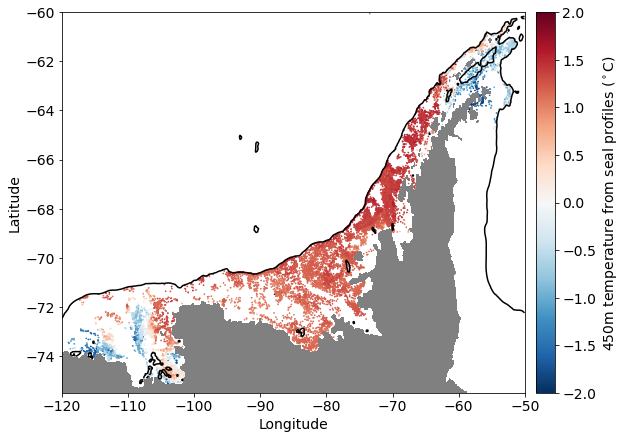

In [17]:
fontsize = 14
depth_slice = 450

plt.figure(figsize=(10,7))
sc = plt.scatter(lon_obs,lat_obs,c=meop_temp,s=.5,cmap='RdBu_r',vmin=-2,vmax=2)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.xlim(-120,-50)
plt.ylim(-75.5,-60)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

Text(0.5, 0, 'Longitude')

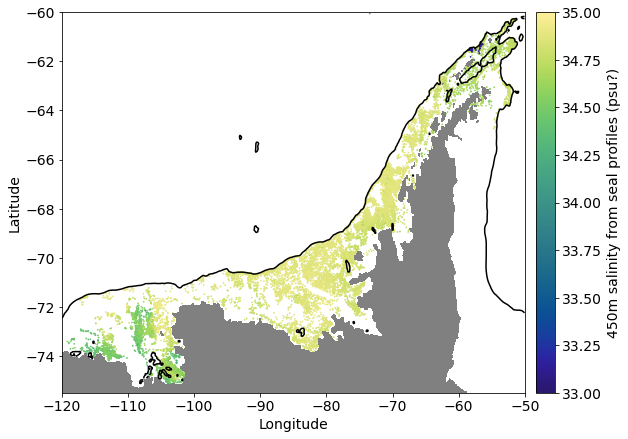

In [27]:
import cmocean # salinity colour bar
fontsize = 14
depth_slice = 450

plt.figure(figsize=(10,7))
sc = plt.scatter(lon_obs,lat_obs,c=meop_salt,s=.5,cmap=cmocean.cm.haline,vmin=33,vmax=35)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m salinity from seal profiles (psu?)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.xlim(-120,-50)
plt.ylim(-75.5,-60)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

## Save interpolated seal data:

In [15]:
[len(meop_temp), len(date)]

[20138, 22312]

In [30]:
[len(meop_salt), len(date)]

[20138, 22312]

In [31]:
data_nr = len(meop_temp) # length of all profiles -> 20138 = I have that many different profiles
meop_temp = xr.DataArray(meop_temp, coords = [np.arange(data_nr)], dims = ['profile_number'], name = 'seal profile cons. temp. interpolated onto model depth grid closest to 450m')
meop_salt = xr.DataArray(meop_salt, coords = [np.arange(data_nr)], dims = ['profile_number'], name = 'seal profile abs. salinity. interpolated onto model depth grid closest to 450m')

lon_obs   = xr.DataArray(lon_obs, coords = [np.arange(data_nr)], dims = ['profile_number'], name = 'longitude of seal profiles')
lat_obs   = xr.DataArray(lat_obs, coords = [np.arange(data_nr)], dims = ['profile_number'], name = 'latitude of seal profiles')
date      = xr.DataArray(date, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'date of seal profiles')

ds = xr.Dataset({'meop_temp': meop_temp,'lon_obs':lon_obs,'lat_obs':lat_obs,'date':date,
                 'meop_salt': meop_salt,'lon_obs':lon_obs,'lat_obs':lat_obs,'date':date})
outpath = '/g/data/e14/mv7494/seal_data_comparison/' + 'WAP_seal_profiles_'+str(depth_slice)+'m_depth_ACCESS-OM2-01.nc'
ds.to_netcdf(outpath)

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #